## Introdução

O cerrado brasileiro possui uma grande diversidade de aves. Algumas delas apresentam um desenvolvimento cerebral maior que outras, como é o caso das aves da família Psittacidae. Diversas aves dessa família são conhecidas como papagaios, araras e periquitos.bEssas aves possuem inteligência superior em comparação às demais, sendo capazes de imitar diferentes sons. Caracterizam-se por um bico alto e curvo, com a parte superior maior que a inferior, além de apresentarem plumagens muito coloridas. Embora sejam bastante bonitas, podem ser difíceis de diferenciar a olho nu por pessoas que não possuem certas especializações. Com o objetivo de facilitar esse processo, a presente rede convolucional tem como finalidade analisar e identificar a espécie da ave a partir de uma imagem.

Para isso, será criada e treinada uma rede convolucional utilizando um conjunto de dados com mais de 3.000 imagens, obtidas a partir do site iNaturalist. O dataset possui diferentes quantidades de imagens para cada espécie e, a fim de equilibrar as classes, serão adicionadas novas imagens, além da aplicação de técnicas de data augmentation.

As especies a serem utilizadas no treinamento serão:

*   Amazona aestiva
*   Amazona amazonica
*   Anodorhynchus hyacinthinus
*   Ara ararauna
*   Ara chloropterus
*   Ara macao
*   Brotogeris chiriri
*   Diopsittaca nobilis
*   Eupsittula aurea
*   Forpus xanthopterygius
*   Orthopsittaca manilatus
*   Primolius maracana
*   Psittacara leucophthalmus
*   Touit melanonotus

Uma rede convolucional funciona a partir de três camadas principais: a camada convolucional, a camada de agrupamento e a camada totalmente conectada. A camada convolucional tem como objetivo dividir a imagem em regiões e aplicar filtros a partir de pesos aprendidos. A camada de agrupamento aplica um filtro sem pesos de treinamento na entrada, a fim de reduzir a quantidade de informações, mantendo apenas as mais relevantes. Por fim, a camada totalmente conectada realiza a classificação e retorna ao usuário a informação final.

A fim de comparar a rede criada, também será realizado o transfer learning a partir de uma arquitetura já consolidada, seguido do fine-tuning. Dessa forma, o resultado final compreenderá três redes convolucionais. A arquitetura utilizada para criar a rede convolucional será a ResNet50; para o transfer learning será empregada a XXXX; e, para o fine-tuning, será aplicada a técnica XXXX.

## Imports

Esta célula faz o import das bibliotecas que serão utilizadas no notebook.


In [24]:
import gdown
import zipfile
import os
import shutil
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import numpy as np

## Download e preparação do dataset

Nesta etapa realizamos o processo completo de obtenção e organização do conjunto de dados.  
O arquivo compactado é baixado do Google Drive por meio da biblioteca **gdown**, armazenado em uma pasta de arquivos **compactados** e, em seguida, descompactado para a pasta **dataset_original**. Após a extração, diretórios e arquivos temporários do sistema (como `__MACOSX` e `.DS_Store`) são removidos, garantindo uma estrutura limpa e padronizada.  

Ao final, temos um dataset pronto para uso, organizado em `datasets/` e pronto para os próximos passos.


In [25]:
file_id = "19rWCGW38ht8TLY1ad7gba46mP5FCIZul"
url = f"https://drive.google.com/uc?id={file_id}"
zip_name = "dataset_original.zip"

base = Path("datasets"); compact = base/"compactados"; extract = base/"dataset_original"
base.mkdir(exist_ok=True); compact.mkdir(parents=True, exist_ok=True); extract.mkdir(parents=True, exist_ok=True)

exts = {".jpg",".jpeg",".png",".bmp",".tiff",".tif",".webp"}
contar_imgs = lambda p: sum(1 for f in p.rglob("*") if f.is_file() and f.suffix.lower() in exts)

def pronto(p):
    return p.exists() and sum(1 for d in p.iterdir() if d.is_dir()) == 14 and contar_imgs(p) == 2879

if pronto(extract):
    print("✅ Dataset já existe.")
else:
    print("📥 Baixando..."); gdown.download(url, zip_name, quiet=False)
    dest = compact/zip_name; dest.unlink(missing_ok=True); shutil.move(zip_name, dest)
    print("📂 Extraindo..."); zipfile.ZipFile(dest).extractall(extract)
    [shutil.rmtree(d, ignore_errors=True) for d in extract.rglob("__MACOSX")]
    [f.unlink(missing_ok=True) for f in extract.rglob(".DS_Store")]
    print(f"📸 Total de imagens: {contar_imgs(extract)}")
    print("✅ Dataset pronto em:", base.resolve())


✅ Dataset já existe.


# Exploração de dados

## Organização do dataset

In [26]:
dataset_path = "./datasets/dataset_original"

### Quantidade total de imagens

In [27]:
total_images = sum(len(files) for _, _, files in os.walk(dataset_path))
total_images

2879

### Número de classes (espécies)

In [28]:
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
num_classes = len(classes)
num_classes

14

## Distribuição das classes

/tmp/ipython-input-2636077454.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x="imagens", y="classe", palette="viridis", orient="h")


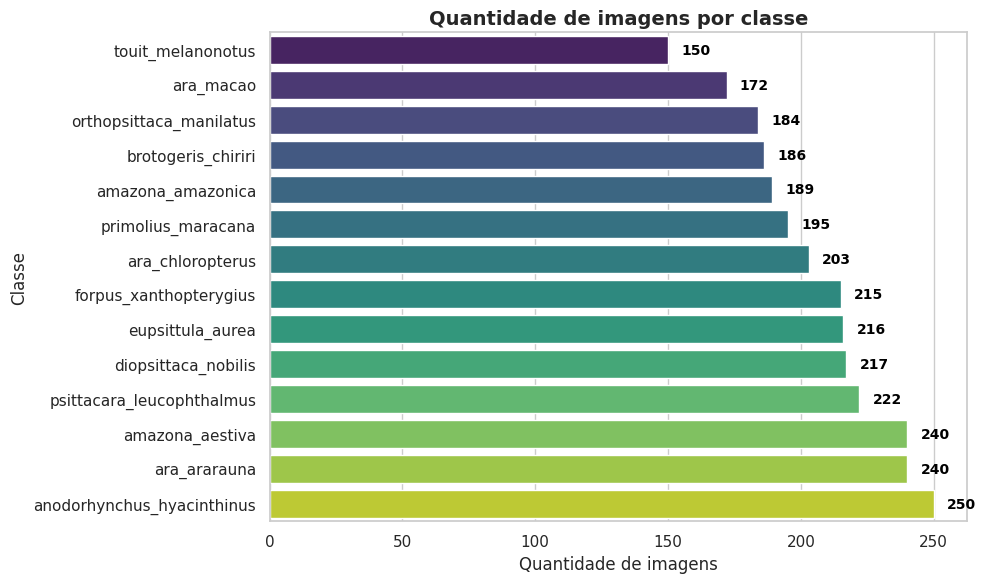

In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset_path = "./datasets/dataset_original"
exts = {".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".tif", ".webp"}

# Contar imagens por classe
registros = []
for classe in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, classe)
    if os.path.isdir(class_dir):
        total = sum(
            1 for root, _, files in os.walk(class_dir)
            for f in files if os.path.splitext(f)[1].lower() in exts
        )
        registros.append({"classe": classe, "imagens": total})

df = pd.DataFrame(registros).sort_values("imagens", ascending=True)

# Estilo seaborn
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x="imagens", y="classe", palette="viridis", orient="h")

# Adicionar valores no final da barra
for i, (valor, classe) in enumerate(zip(df["imagens"], df["classe"])):
    ax.text(valor + 5, i, f"{valor}", va="center", fontweight="bold", fontsize=10, color="black")

plt.title("Quantidade de imagens por classe", fontsize=14, fontweight="bold")
plt.xlabel("Quantidade de imagens", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.tight_layout()
plt.show()


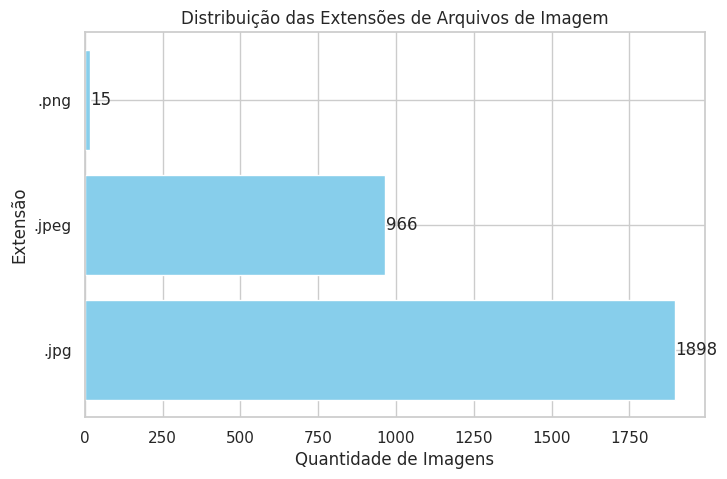

In [30]:

# Lista para armazenar extensões
extensoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext:  # garante que tem extensão
            extensoes.append(ext)

# Conta as ocorrências de cada extensão
contagem = Counter(extensoes)

# Separa chaves e valores
extensoes_unicas = list(contagem.keys())
quantidades = list(contagem.values())

# Cria gráfico de barras horizontal
plt.figure(figsize=(8,5))
bars = plt.barh(extensoes_unicas, quantidades, color="skyblue")
plt.xlabel("Quantidade de Imagens")
plt.ylabel("Extensão")
plt.title("Distribuição das Extensões de Arquivos de Imagem")

# Adiciona os valores na frente das barras
for bar, qtd in zip(bars, quantidades):
    plt.text(qtd + 0.5, bar.get_y() + bar.get_height()/2,
             str(qtd), va="center")

plt.show()

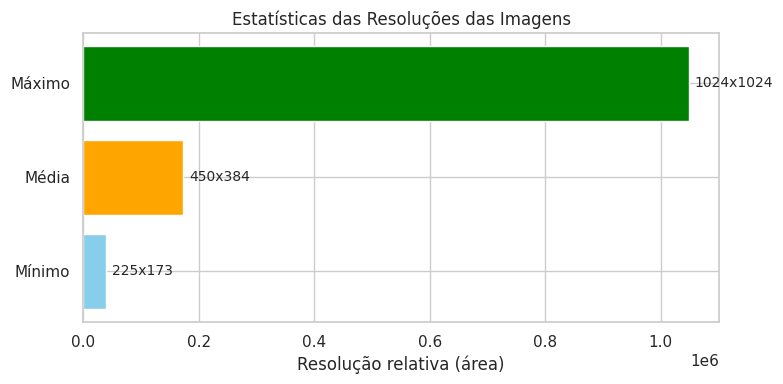

In [34]:

# Lista para armazenar resoluções
resolucoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"]:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    w, h = img.size
                    resolucoes.append((w, h))
            except:
                pass

# Estatísticas
larguras = [w for w, h in resolucoes]
alturas = [h for w, h in resolucoes]

res_min = (min(larguras), min(alturas))
res_max = (max(larguras), max(alturas))
res_media = (int(np.mean(larguras)), int(np.mean(alturas)))

# Lista de barras com valores e rótulos
barras = [
    ("Mínimo", res_min),
    ("Média", res_media),
    ("Máximo", res_max)
]

# Ordena por largura*altura (área da imagem)
barras.sort(key=lambda x: x[1][0]*x[1][1])

# Extrai dados para plot
nomes = [nome for nome, res in barras]
res_labels = [f"{res[0]}x{res[1]}" for nome, res in barras]
valores = [res[0]*res[1] for nome, res in barras]  # usado só para tamanho da barra

# Cria gráfico horizontal
plt.figure(figsize=(8,4))
bars = plt.barh(range(len(nomes)), valores, color=["skyblue", "orange", "green"])
plt.yticks(range(len(nomes)), nomes)
plt.xlabel("Resolução relativa (área)")
plt.title("Estatísticas das Resoluções das Imagens")

# Adiciona rótulo [LxA] na frente de cada barra
for bar, label in zip(bars, res_labels):
    plt.text(bar.get_width() + max(valores)*0.01,
             bar.get_y() + bar.get_height()/2,
             label, va="center", fontsize=10)

plt.tight_layout()
plt.show()


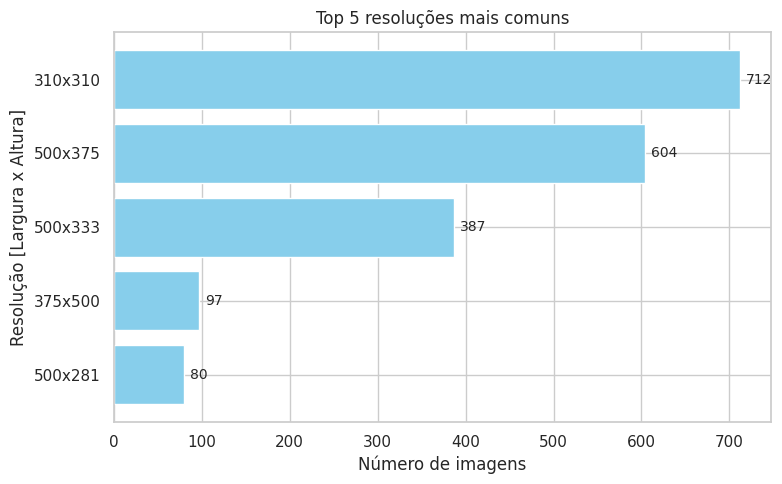

In [42]:
resolucoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"]:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    w, h = img.size
                    resolucoes.append(f"{w}x{h}")  # guarda como string "LxA"
            except:
                pass  # ignora arquivos corrompidos

# Conta quantas imagens têm cada resolução
contagem = Counter(resolucoes)

# Pega as 5 resoluções mais comuns
top5 = contagem.most_common(5)  # retorna lista de tuplas: [(resolucao, quantidade), ...]

# Separa em listas para plot
resolucoes_top5 = [item[0] for item in top5]
quantidades_top5 = [item[1] for item in top5]

# Cria gráfico horizontal
plt.figure(figsize=(8,5))
# inverte listas para colocar a maior barra em cima
bars = plt.barh(resolucoes_top5[::-1], quantidades_top5[::-1], color="skyblue")
plt.xlabel("Número de imagens")
plt.ylabel("Resolução [Largura x Altura]")
plt.title("Top 5 resoluções mais comuns")

# Adiciona número de imagens na frente de cada barra
for bar, qtd in zip(bars, quantidades_top5[::-1]):
    plt.text(qtd + max(quantidades_top5)*0.01,
             bar.get_y() + bar.get_height()/2,
             str(qtd), va="center", fontsize=10)

plt.tight_layout()
plt.show()

In [41]:
contagem = Counter(resolucoes)

total_resolucoes = len(contagem)
print(f"Número total de resoluções únicas: {total_resolucoes}")

Número total de resoluções únicas: 361
